# Process Memory Usage Results

This generates plots of dynamic allocations over time by node. The standard ros2 CLI component process names will be ignored by default.

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

import os

In [75]:
path = "/home/autera/cavauto/scripts/utils/ros2_tracing_cpp/build/plugins/memory_usage_metadata.csv"
"""The location of the memory usage metedata"""

BUFFER_PERIOD = 15
"""The time in seconds to ignore"""

mem_df = pd.read_csv(path)
mem_df

,path,vpid,procname,avg_alloc_lifecycle,avg_alloc_size,allocation_count,max_memory
0,mem_recv.csv,2005158,recv,32861168354,321,432661,912090
1,mem_recvUC.csv,2005170,recvUC,128850708716,384,1063530,57095
2,mem_recvUC.csv,2005166,recvUC,3615642389,160,19573,82304
3,mem_recvUC.csv,2005168,recvUC,15337562552,154,18944,140206
4,mem_recvUC.csv,2005174,recvUC,3663076043,887,1229749,48144449
5,mem_long_control_no.csv,2005162,long_control_no,4710423174,368,127855,100463
6,mem_graceful_stop_n.csv,2005164,graceful_stop_n,8675790029,609,128154,1230345
7,mem_path_server_nod.csv,2005172,path_server_nod,6969635760,214,148834,3333430
8,mem_tev.csv,2005176,tev,5015400083,381,50033,786520


In [76]:
BANNED_PROCESS_NAMES = ['recv', 'recvUC']
"""Ros2 default process names which should not be analyzed"""
ALLOCATION_TYPES = ['malloc', 'calloc', 'realloc', 'memalign', 'posix_memalign']
"""The kinds of allocations which can be made"""

non_banned_processes = ~mem_df['procname'].isin(BANNED_PROCESS_NAMES)
max_memory_is_significant = mem_df['max_memory'] > 100 * 2 << 10

combined_filter = non_banned_processes
combined_filter &= max_memory_is_significant

mem_df = mem_df[combined_filter]
mem_df

,path,vpid,procname,avg_alloc_lifecycle,avg_alloc_size,allocation_count,max_memory
6,mem_graceful_stop_n.csv,2005164,graceful_stop_n,8675790029,609,128154,1230345
7,mem_path_server_nod.csv,2005172,path_server_nod,6969635760,214,148834,3333430
8,mem_tev.csv,2005176,tev,5015400083,381,50033,786520


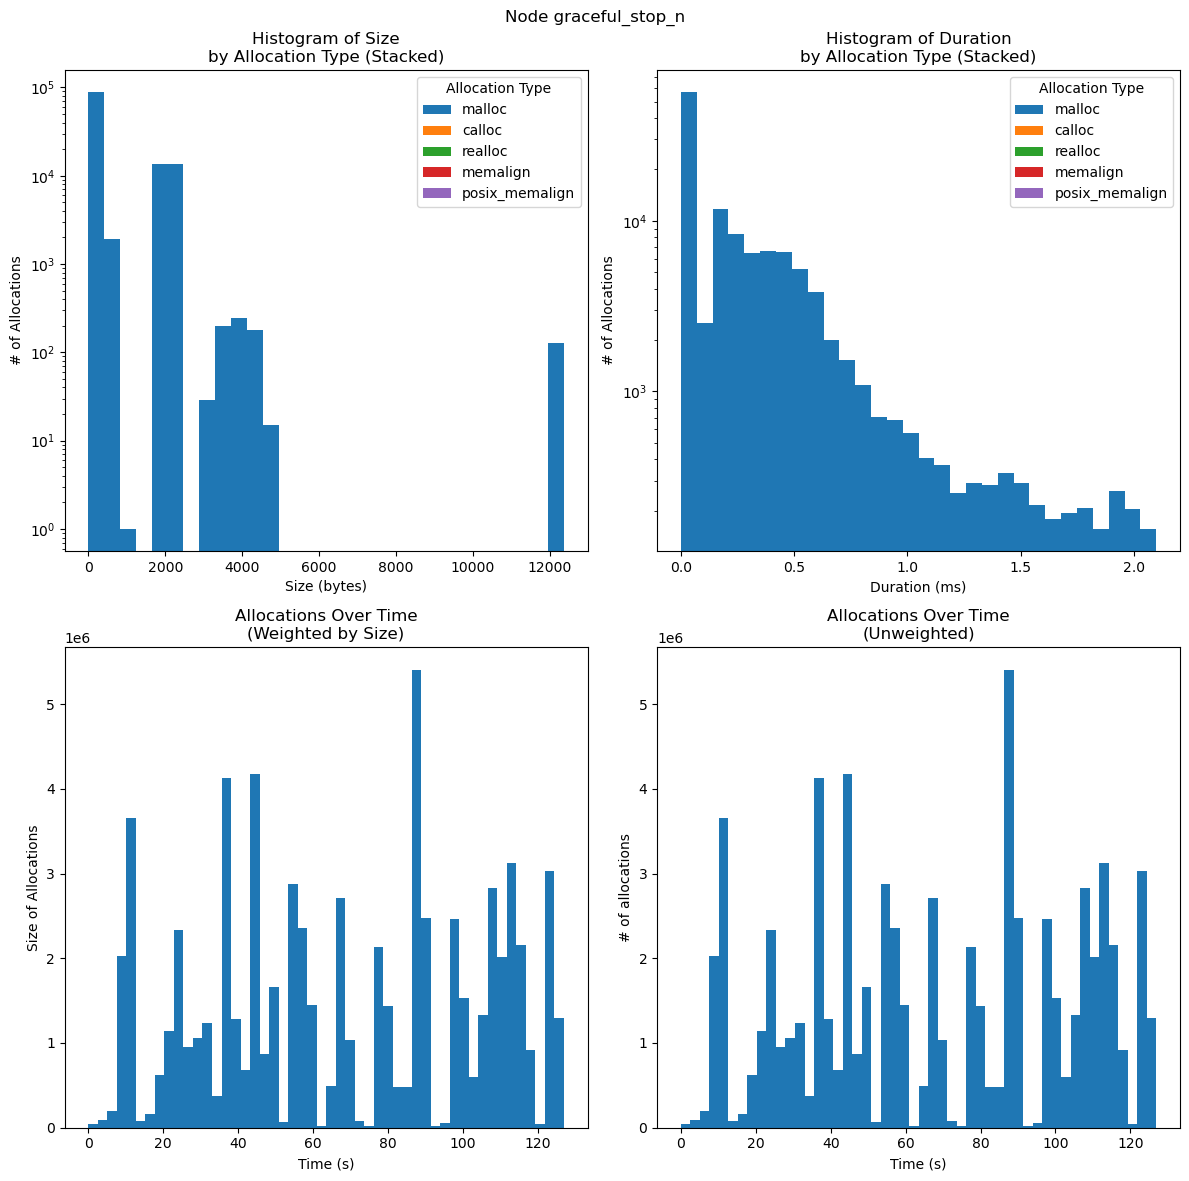

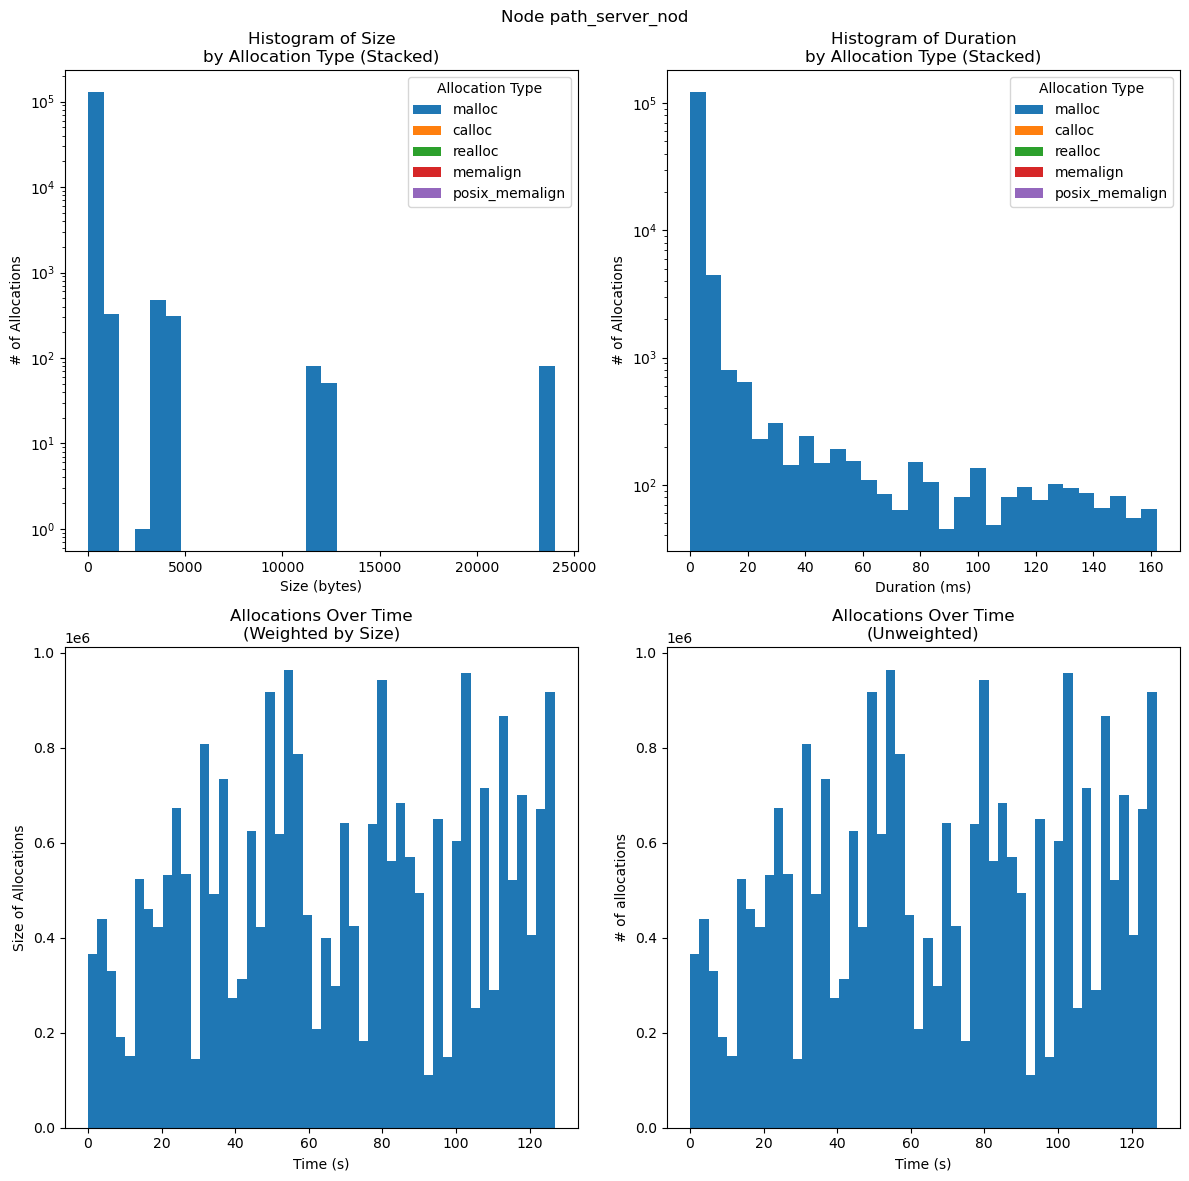

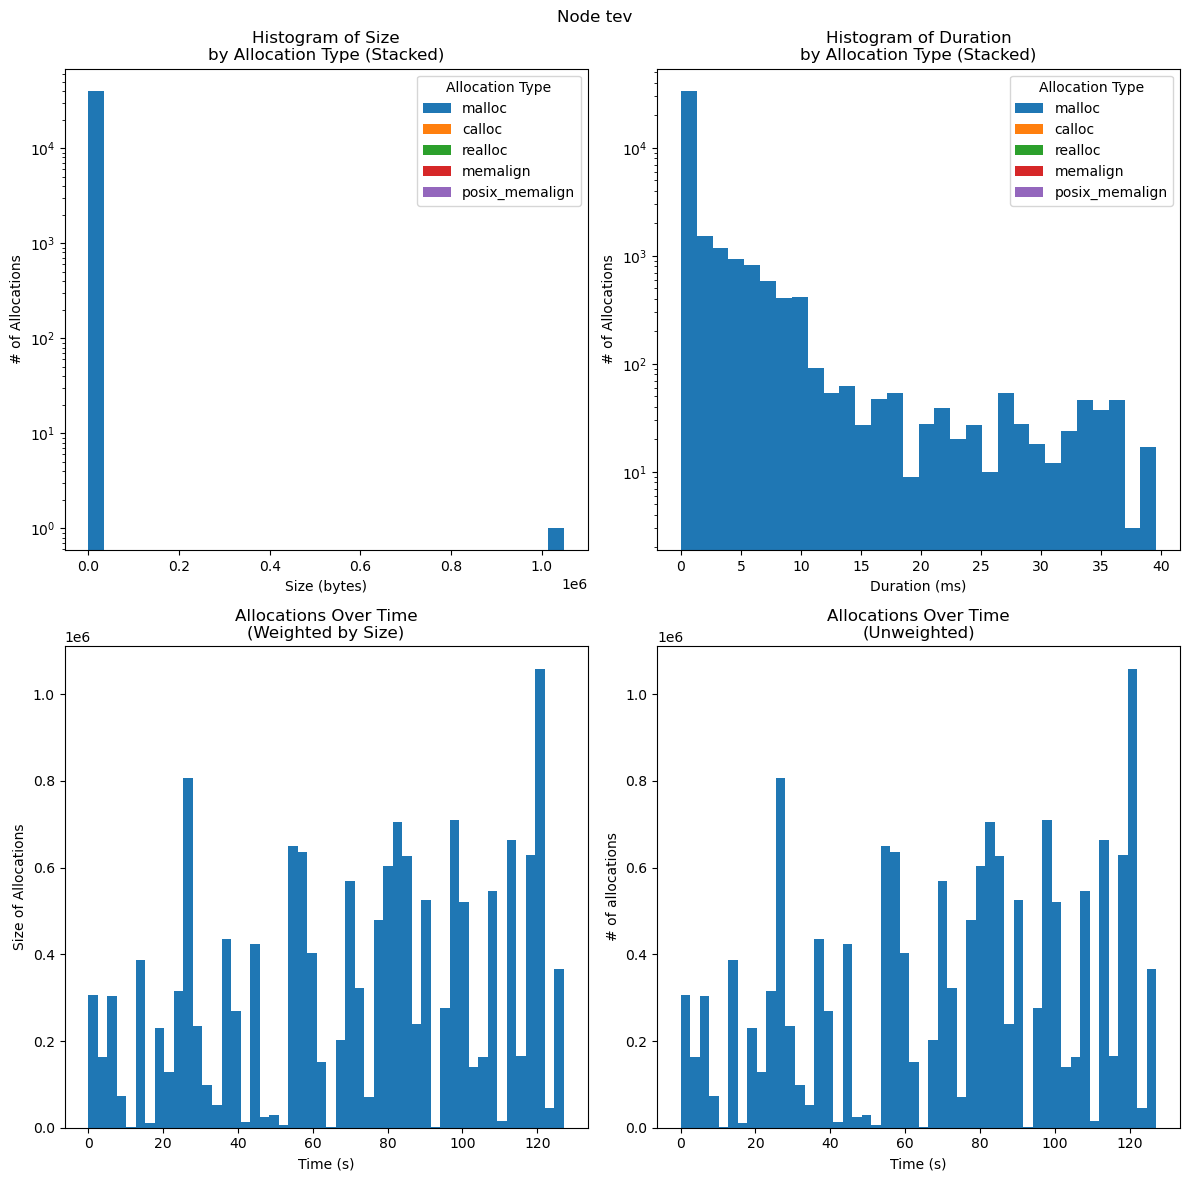

In [77]:
def make_allocations_over_time_graph(row: dict) -> plt.Figure:
    """
    Makes a graph of allocations over time

    :param dict row: the row of the `mem_df` table 
    """

    dirname = os.path.dirname(path)
    filename = row['path']
    filepath = os.path.join(dirname, filename)
    df = pd.read_csv(filepath)

    # turn time in nsecs from the origin into a datetime
    min_time = df['time'].min()
    df['time'] = df['time'] - min_time
    df['time'] /= 1e9
    df['time'] -= BUFFER_PERIOD
    df = df[df['time'] > 0]

    df['duration'] /= 1e6 # turning duration into miliseconds

    # calculating q95 duration
    q95_duration = df['duration'].quantile(0.95)
    df = df[df['duration'] < q95_duration] # avoids objects which are never deallocated

    fig, ((allocation_size, lifecycle), (over_time, over_time_calls)) = plt.subplots(2, 2, figsize=(12, 12))

    # allocation size
    sizes_by_type = [df[df['type'] == allocation_type]['size'] for allocation_type in ALLOCATION_TYPES]

    allocation_size.hist(sizes_by_type, bins=30, stacked=True, label=ALLOCATION_TYPES, log=True)
    allocation_size.set_title("Histogram of Size\nby Allocation Type (Stacked)")
    allocation_size.set_xlabel("Size (bytes)")
    allocation_size.set_ylabel("# of Allocations")
    allocation_size.legend(title="Allocation Type")

    # lifecycle analysis
    durations_by_type = [df[df['type'] == allocation_type]['duration'] for allocation_type in ALLOCATION_TYPES]
    
    lifecycle.hist(durations_by_type, bins=30, stacked=True, label=ALLOCATION_TYPES, log=True)
    lifecycle.set_title("Histogram of Duration\nby Allocation Type (Stacked)")
    lifecycle.set_xlabel("Duration (ms)")
    lifecycle.set_ylabel("# of Allocations")
    lifecycle.legend(title="Allocation Type")

    HIST_BINS = 50
    """Number of bins in both histograms (must be the same)"""

    # Histogram of allocations over time weighted by size (unchanged)
    over_time.hist(df['time'], bins=HIST_BINS, weights=df['size'])
    over_time.set_title("Allocations Over Time\n(Weighted by Size)")
    over_time.set_xlabel("Time (s)")
    over_time.set_ylabel("Size of Allocations")

    # Histogram of allocations over time unweighted
    over_time_calls.hist(df['time'], bins=HIST_BINS, weights=df['size'])
    over_time_calls.set_title("Allocations Over Time\n(Unweighted)")
    over_time_calls.set_xlabel("Time (s)")
    over_time_calls.set_ylabel("# of allocations")

    fig.suptitle(f"Node {row['procname']}")
    plt.tight_layout()
    plt.show()

_ = mem_df.apply(make_allocations_over_time_graph, axis=1)    